## Represent a graph as an adjacency list
Directed graph can be represented as a list of edges where each edge is a tuple (source_node_index, destination_node_index)

In [1]:
class BasicGraph:
    def __init__(self, vlist=[]):
        """ Initialize a Graph with an optional vertex list """
        self.index = {v:i for i,v in enumerate(vlist)}    # looks up index given name
        self.vertex = {i:v for i,v in enumerate(vlist)}   # looks up name given index
        self.edge = []
        self.edgelabel = []
        
    def addVertex(self, label):
        """ Add a labeled vertex to the graph """
        index = len(self.index)
        self.index[label] = index
        self.vertex[index] = label
        
    def addEdge(self, vsrc, vdst, label='', repeats=True):
        """ Add a directed edge to the graph, with an optional label. 
        Repeated edges are distinct, unless repeats is set to False. """
        e = (self.index[vsrc], self.index[vdst])
        if (repeats) or (e not in self.edge):
            self.edge.append(e)
            self.edgelabel.append(label)

## Add a method to search for Hamiltonian path
The BasicGraph extended with a Branch-and-bound Hamiltonian Path method

In [2]:
import itertools

class ImprovedGraph(BasicGraph):
    
    def SearchTree(self, path, verticesLeft):
        """ A recursive Branch-and-Bound Hamiltonian Path search. 
        Paths are extended one node at a time using only available
        edges from the graph. """
        if (len(verticesLeft) == 0):
            self.PathV2result = [self.vertex[i] for i in path]
            return True
        for v in verticesLeft:
            if (len(path) == 0) or ((path[-1],v) in self.edge):
                if self.SearchTree(path+[v], [r for r in verticesLeft if r != v]):
                    return True
        return False
    
    def hamiltonianPath(self):
        """ A wrapper function for invoking the Branch-and-Bound 
        Hamiltonian Path search. """
        self.PathV2result = []
        self.SearchTree([],sorted(self.index.values())) # "index.values()" is a list of nodes           
        return self.PathV2result

## Add a method to search for Eulerian path


In [3]:
class AwesomeGraph(ImprovedGraph):

    def degrees(self):
        """ Returns two dictionaries with the inDegree and outDegree
        of each node from the graph. """
        inDegree = {}
        outDegree = {}
        for src, dst in self.edge:
            outDegree[src] = outDegree.get(src, 0) + 1
            inDegree[dst] = inDegree.get(dst, 0) + 1
        return inDegree, outDegree
    
    def verifyAndGetStart(self):
        """ start node should have out_degree = in_degree + 1, or 
        an Eulerian cycle exists if all nodes have equeal in and out
        degrees.
        """
        inDegree, outDegree = self.degrees()
        start, end = 0, 0
        # node 0 will be the starting node if a Euler cycle is found
        for vert in self.vertex:
            ins = inDegree.get(vert,0)
            outs = outDegree.get(vert,0)
            if (ins == outs):
                continue
            elif (ins - outs == 1):
                end = vert
            elif (outs - ins == 1):
                start = vert
            else:
                start, end = -1, -1
                break
        if (start >= 0) and (end >= 0):
            return start
        else:
            return -1
        
    def eulerianPath(self):
        graph = [(src,dst) for src,dst in self.edge]
        currentVertex = self.verifyAndGetStart()
        path = [currentVertex]
        # "next" is the list index where vertices get inserted into our tour
        # it starts at the end (i.e. same as appending), but later "side-trips" will insert in the middle
        next = 1
        while (len(graph) > 0):                   # when all edges are used, len(graph) == 0
            # follows a path until it ends
            for edge in graph:
                if (edge[0] == currentVertex):
                    currentVertex = edge[1]
                    graph.remove(edge)
                    path.insert(next, currentVertex)  # inserts vertex in path
                    next += 1
                    break
            else:
                # Look for side-trips along the current path
                for edge in graph:
                    try:
                        # insert our side-trip after the "u" vertex that is starts from
                        next = path.index(edge[0]) + 1
                        currentVertex = edge[0]
                        break
                    except ValueError:
                        continue
                else:
                    print("There is no path!")
                    return False
        return path

    def eulerEdges(self, path):
        edgeId = {}
        for i in range(len(self.edge)):
            edgeId[self.edge[i]] = edgeId.get(self.edge[i], []) + [i]
        edgeList = []
        for i in range(len(path)-1):
            edgeList.append(self.edgelabel[edgeId[path[i],path[i+1]].pop()])            
        return edgeList

    def render(self, highlightPath=[]):
        """ Outputs a version of the graph that can be rendered
        using graphviz tools (http://www.graphviz.org/)."""
        edgeId = {}
        for i in range(len(self.edge)):
            edgeId[self.edge[i]] = edgeId.get(self.edge[i], []) + [i]
        edgeSet = set()
        for i in range(len(highlightPath)-1):
            src = self.index[highlightPath[i]]
            dst = self.index[highlightPath[i+1]]
            edgeSet.add(edgeId[src,dst].pop())
        result = ''
        result += 'digraph {\n'
        result += '   graph [nodesep=2, size="10,10"];\n'
        for index, label in self.vertex.items():
            result += '    N%d [shape="box", style="rounded", label="%s"];\n' % (index, label)
        for i, e in enumerate(self.edge):
            src, dst = e
            result += '    N%d -> N%d' % (src, dst)
            label = self.edgelabel[i]
            if (len(label) > 0):
                if (i in edgeSet):
                    result += ' [label="%s", penwidth=3.0]' % (label)
                else:
                    result += ' [label="%s"]' % (label)
            elif (i in edgeSet):
                result += ' [penwidth=3.0]'                
            result += ';\n'                
        result += '    overlap=false;\n'
        result += '}\n'
        return result
    
    

In [5]:
n = 4
binary = [''.join(t) for t in itertools.product('01', repeat=n)]

# graph nodes are n-1 mers of input binary number strings
nodes = sorted(set([code[:-1] for code in binary] + [code[1:] for code in binary]))
G2 = AwesomeGraph(nodes)
for code in binary:
   # An edge is added between nodes from the same string, and labeled with the string 
   G2.addEdge(code[:-1],code[1:],code)

%timeit G2.eulerianPath()
path = G2.eulerianPath()
print("Graph nodes:", nodes)
print("Eulerian path:", path)
edges = G2.eulerEdges(path)
print("Eulerian path edges:", edges)
print("Superstring:", edges[0] + ''.join([edges[i][-1] for i in range(1,len(edges))]))

15.3 µs ± 760 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Graph nodes: ['000', '001', '010', '011', '100', '101', '110', '111']
Eulerian path: [0, 0, 1, 3, 7, 7, 6, 5, 3, 6, 4, 1, 2, 5, 2, 4, 0]
Eulerian path edges: ['0000', '0001', '0011', '0111', '1111', '1110', '1101', '1011', '0110', '1100', '1001', '0010', '0101', '1010', '0100', '1000']
Superstring: 0000111101100101000


In [6]:
render = G2.render()
print(render)
with open("TestGraph.dot", 'w') as fp:
    fp.write(render)

digraph {
   graph [nodesep=2, size="10,10"];
    N0 [shape="box", style="rounded", label="000"];
    N1 [shape="box", style="rounded", label="001"];
    N2 [shape="box", style="rounded", label="010"];
    N3 [shape="box", style="rounded", label="011"];
    N4 [shape="box", style="rounded", label="100"];
    N5 [shape="box", style="rounded", label="101"];
    N6 [shape="box", style="rounded", label="110"];
    N7 [shape="box", style="rounded", label="111"];
    N0 -> N0 [label="0000"];
    N0 -> N1 [label="0001"];
    N1 -> N2 [label="0010"];
    N1 -> N3 [label="0011"];
    N2 -> N4 [label="0100"];
    N2 -> N5 [label="0101"];
    N3 -> N6 [label="0110"];
    N3 -> N7 [label="0111"];
    N4 -> N0 [label="1000"];
    N4 -> N1 [label="1001"];
    N5 -> N2 [label="1010"];
    N5 -> N3 [label="1011"];
    N6 -> N4 [label="1100"];
    N6 -> N5 [label="1101"];
    N7 -> N6 [label="1110"];
    N7 -> N7 [label="1111"];
    overlap=false;
}



In [1]:
# The following command assumes that graphviz is installed.
# See https://www.graphviz.org/
!circo -Goverlap=scale -Tpng TestGraph.dot -o TestGraph.png

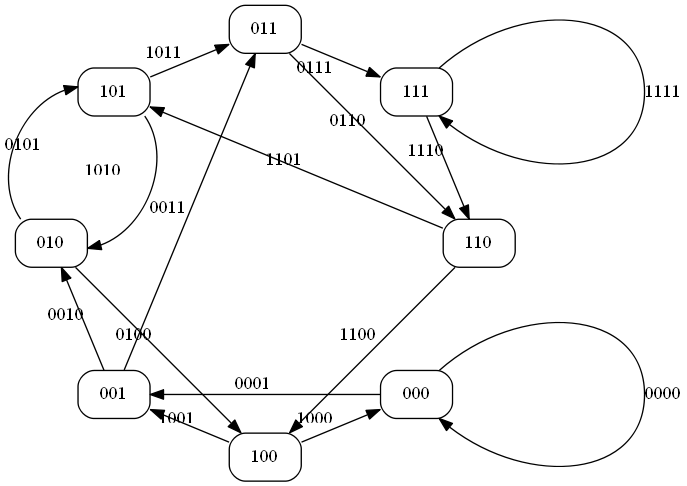

In [2]:
from IPython.display import Image
Image('TestGraph.png')